# Welcome!

This ipython notebook implements a simple Neural Nets aimed at classifying the MNIST dataset

This code is mostly aimed for those who are familiar with the basics of Neural Networks, and want to see and understand an actual practical implementation.

As such, this code doesn't use any higher level libraries such as Tensorflow. (It only makes extensive use of Numpy.)

It also means that it is much easier to follow variables around, and see how different building blocks interact with each other to form a full-fledged net. This all comes at the drawback of not being able to use very optimized implementations.

Therefore, although the presented net seems quite robust, it is also hard to optimize and converge, and have very good performance. Again, this code is meant for understanding and 'playing around', not aimed at high-end performance.

<br />

### I hope this gives an easy to follow code and a good overview of what happens inside a Neural Nets step by step, and that many people may benefit from tinkering with it.

## Anner

<br /> <br />

NB:
* Everything is included in this single iPython Notebook, EXCEPT:
* The MNIST data. Please download these into the correct directory (explanation below)


Lacking:

* ReLU layer, other activation functions
* Optimized initialisation of the weight variables such as Glorot/Xavier initialisation
* Visualize different nets training characteristics next to each other
* Conv nets are actually included in the building blocks, but not used. A new network class could add these layers


# Import Libraries & building blocks
### This is rather long, best to fold it and go over specific blocks once you feel like it

In [9]:
################################## Neural Network Hulp/Utility functions ##################################
# Here you can find a lot of building blocks for Neural Nets, sorry for not providing more detailed explanations
# Some of these were build based on, or even copied from, my implementation for Stanford's cs231n class's homework assignments

from matplotlib import pyplot as plt
import numpy as np
import struct
import copy

###################### Affine layer ########################

def affine_layer_forward(inp, W, b):
    # implements vanilla foward neural net layer, assumes all input to be numpy
    out   = np.add(np.matmul(inp, W), b)
    cache = (inp, W)
    return out, cache

def affine_layer_backward(dout, cache):
    # implements derivative of vanilla foward neural net layer, assumes all input to be numpy
    inp, W = cache
    db     = np.sum(dout, axis=0)
    dW     = np.dot(inp.T, dout)
    dinp   = np.dot(dout, W.T)
    return dinp, dW, db

###################### Activation functions ################

def sigmoid_forward(un_act):
    # implements sigmoid activation function, assumes all input to be numpy
    out   = 1 / (1 + np.exp(-un_act))
    cache = un_act
    return out, cache

def sigmoid_backward(dout, cache):
    # implements derivative of sigmoid acitvation function
    un_act  = cache
    dsig, _ = sigmoid_forward(un_act) #- np.power(sigmoid_forward(un_act), 2)
    dun_act = np.multiply(dsig, dout)
    return dun_act

def softmax_forward(un_act):
    # implements softmax for prediction layer, assumes all input to be numpy
    # (no backward cause only used for last layer in combination with Cross Entropy Loss)
    exp   = np.exp(un_act)
    e_sum = np.sum(exp, axis=1, keepdims=True)
    out   = exp/e_sum
    return out

###################### 'Add-ons'  ##########################

def dropout_forward(inp, p):
    # implements dropout function, assumes all input to be numpy
    #out   = 1 / (1 + np.exp(-un_act))
    mask  = None
    mask  = np.random.rand(*inp.shape) > p
    out   = np.multiply(mask, inp) / (1 - p)
    cache = (p, mask)
    return out, cache

def dropout_backward(dout, cache):
    # implements derivative of dropout function
    p, mask = cache
    dinp = np.multiply(dout, mask) / (1 - p)
    return dinp

def batch_norm_forward(inp, gamma, beta, bn_param):
    # implements batch normalization function, assumes all input to be numpy
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = inp.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=inp.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=inp.dtype))

    out, cache = None, None
    if mode == 'train':

        inp_mean = np.sum(inp, axis=0) / N

        inp_susq = np.sum(np.power(inp, 2), axis=0)
        inp_sqsu = np.power(np.sum(inp, axis=0), 2)
        inp_var = inp_susq / N - inp_sqsu / (N * N)
        inp_std = np.sqrt(inp_var + eps)

        inp_nor = (inp - inp_mean) / inp_std

        out = gamma * inp_nor + beta

        running_mean = momentum * running_mean + (1 - momentum) * inp_mean
        running_var  = momentum * running_var + (1 - momentum) * inp_var

        cache = (inp, inp_std, inp_nor, gamma, eps)

    else:

        inp_mean = (inp - running_mean)
        inp_std = np.sqrt(running_var + eps)
        inp_nor = inp_mean / inp_std

        out = gamma * inp_nor + beta

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache

def batch_norm_backward(dout, cache):
    # implements derivative of batch normalization function

    dinp, dgamma, dbeta = None, None, None
    inp, inp_std, inp_nor, gamma, eps = cache
    inp_mu = np.mean(inp, axis=0)
    N, D = inp.shape

    dinp_nor = np.multiply(dout, gamma)

    dinp = (1. / inp_std) * (
    dinp_nor - (np.sum(dinp_nor, axis=0) / N) - (inp - inp_mu) * np.sum((inp - inp_mu) * dinp_nor, axis=0) * (inp_std ** (-2.) / N))
    dgamma = np.sum(np.multiply(dout, inp_nor), axis=0)
    dbeta = np.sum(dout, axis=0)

    return dinp, dgamma, dbeta

###################### Often used layer combinations  ######

def sigmoid_layer_forward(inp, W, b):
    # implements vanilla foward neural net layer, plus a sigmoid activation, assumes all input to be numpy
    un_act, fc_cache  = affine_layer_forward(inp, W, b)
    out,    sig_cache = sigmoid_forward(un_act)
    return out, (fc_cache, sig_cache)

def sigmoid_layer_backward(dout, cache):
    # implements derivatives of vanilla foward neural net layer, plus a sigmoid activation, assumes all input to be numpy
    fc_cache, sig_cache = cache
    dun_act      = sigmoid_backward(dout, sig_cache)
    dinp, dW, db = affine_layer_backward(dun_act, fc_cache)
    return dinp, dW, db

def BN_Dr_sig_layer_forward(inp, W, b, drop, gam, bet, bn_param):
    # implements vanilla foward neural net layer, then BN, then Dropout, then a sigmoid activation, assumes all input to be numpy
    un_act, fc_cache  = affine_layer_forward(inp, W, b)
    BN,     BN_cache  = batch_norm_forward(un_act, gam, bet, bn_param)
    Drop,   Dr_cache  = dropout_forward(BN, drop)
    out,    sig_cache = sigmoid_forward(Drop)
    return out, (fc_cache, BN_cache, Dr_cache, sig_cache)

def BN_Dr_sig_layer_backward(dout, cache):
    # implements derivatives of vanilla foward neural net layer, then BN, then Dropout, then a sigmoid activation, assumes all input to be numpy
    fc_cache, BN_cache, Dr_cache, sig_cache = cache
    dun_act         = sigmoid_backward(dout, sig_cache)
    dDrop           = dropout_backward(dun_act, Dr_cache)
    dBN, dgam, dbet = batch_norm_backward(dDrop, BN_cache)
    dinp, dW, db    = affine_layer_backward(dBN, fc_cache)
    return dinp, dW, db, dgam, dbet

def softmax_layer_forward(inp, W, b):
    # implements vanilla foward neural net layer, plus a softmax, for final prediction layer, assumes all input to be numpy
    un_act, cache = affine_layer_forward(inp, W, b)
    out           = softmax_forward(un_act)
    return out, cache

###################### Loss function #######################

def cross_entropy_loss(y_pred, y_gt):
    # implements cross entropy loss and its derivative, assumes y as one hot encoded
    loss   = np.mean(np.sum((y_gt * -np.log(y_pred)), axis=1))
    d_pred = np.subtract(y_pred, y_gt)
    return loss, d_pred

###################### other ###############################

def get_random_batch(X, y, batch_size):
    # get a random batch from X and y for network training
    N      = X.shape[0]
    idx    = np.arange(N)
    np.random.shuffle(idx)
    ba_idx = idx[:batch_size]
    X_ba, y_ba = X[ba_idx], y[ba_idx]

    return X_ba, y_ba

###################### Convolutional layer #################

def conv_layer_forward(inp, W, b):

    # This is a low key implementation, so not for performance but for readability
    # ('only' 2 x slower than optimized cython implementation though for the forward pass)
    # For faster implementation, you might want to take a look at im2col and col2im methods, and Cython implementations
    #
    # cs231n:
    # The input consists of N data points, each with C channels, height H and width
    # W. We convolve each input with F different filters, where each filter spans
    # all C channels and has height HH and width WW (HH?).
    #
    # Input:
    # - x: Input data of shape (N, C, H, W)
    # - w: Filter weights of shape (F, C, wH, wW)
    # - b: Biases, of shape (F,)
    # - conv_param: A dictionary with the following keys:
    #   - 'stride': The number of pixels between adjacent receptive fields in the
    #     horizontal and vertical directions.
    #   - 'pad': The number of pixels that will be used to zero-pad the input.
    #
    # Returns a tuple of:
    # - out: Output data, of shape (N, F, oH, oW) where H' and W' are given by
    #   oH = 1 + (H + 2 * pad - wH) / stride
    #   oW = 1 + (W + 2 * pad - wW) / stride
    # - cache: (x, w, b, conv_param)

    out = None

    # key values
    N, C, h, w = inp.shape
    F, C, Wh, Ww = W.shape

    pad = divmod(Ww, 2)[0]
    str = 1

    ph = h + 2 * pad
    pw = w + 2 * pad

    oh = int(round(1 + (ph - Wh) / str))
    ow = int(round(1 + (pw - Ww) / str))

    # padding    x_p
    x_p = np.pad(inp, ((0, 0), (0, 0), (pad, pad), (pad, pad)), 'constant')

    # input column    x_col (N, C, H, W)   -> (N, C*wH*wW, oH, oW)
    # retrieving correct indexes
    or2d_ind = (np.arange(Wh) * ph)[:, None] + np.arange(Ww)
    or3d_ind = (np.arange(C) * ph * pw)[:, None] + or2d_ind.ravel()
    strides = (np.arange(oh) * ph * str)[:, None] + np.arange(ow) * str
    str_ind = np.ravel(or3d_ind)[:, None] + strides.ravel()
    sam_ind = ((str_ind)[None, :] + (np.arange(N) * ph * pw * C)[:, None, None])

    x_col = np.take(x_p, sam_ind)

    # weight column    w_col (F, C, wH, wW) -> (F, C*wH*wW)
    w_col = np.reshape(W, (F, C * Wh * Ww))

    # output column    out   (N, F, oH, oW)
    out_col = np.einsum('ijk,lj->ilk', x_col, w_col) + b[None, :, None]
    out = np.reshape(out_col, (N, F, oh, ow))

    cache = (inp, x_col, W, b)
    return out, cache

def conv_layer_backward(dout, cache):
    # This is a low key implementation (using for loops), so not for performance but for readability
    # For faster implementation, you might want to take a look at im2col and col2im methods, and Cython implementations
    #
    # cs231n:
    #
    # Inputs:
    # - dout: Upstream derivatives.
    # - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive
    #
    # Returns a tuple of:
    # - dx: Gradient with respect to x
    # - dw: Gradient with respect to w
    # - db: Gradient with respect to b

    dx, dw, db = None, None, None

    # forward pass cache
    x, x_col, w, b = cache

    # key values
    N, C, H, W = x.shape
    F, C, wH, wW = w.shape

    pad = divmod(w.shape[-1],2)[0]
    str = 1

    pH = H + 2 * pad
    pW = W + 2 * pad

    oH = int(round(1 + (pH - wH) / str))
    oW = int(round(1 + (pW - wW) / str))

    # x gradients - for loop way
    d_col = np.reshape(dout, (N, F, oH * oW))
    w_col = np.reshape(w, (F, C * wH * wW))
    dx_col = np.sum(np.multiply(w_col[None, :, :, None], d_col[:, :, None, :]), 1)
    dx_cube = np.reshape(dx_col, (N, C, wH, wW, oH * oW))

    dx_p = np.zeros((N, C, H + 2 * pad, W + 2 * pad), dtype=dx_col.dtype)
    for xx in range(oW):
        for yy in range(oH):
            dx_p[:, :, yy * str:yy * str + wH, xx * str:xx * str + wW] += dx_cube[:, :, :, :, yy * oW + xx]

    dinp = dx_p[:, :, pad:-pad, pad:-pad]

    # x gradients - col2im way - about the same speed
    # ---------------------------------------------------------------------------#
    # dout_reshaped = dout.transpose(1, 2, 3, 0).reshape(F, -1)
    # dx_cols = w.reshape(F, -1).T.dot(dout_reshaped)
    # dx = col2im_indices(dx_cols, x.shape, wH, wW, pad, str)

    # x gradients - indexing way - slower
    # ---------------------------------------------------------------------------#
    # retrieving correct indexes
    # C_ind    = np.tile(np.tile(np.arange(C) [:,None], wH*wW).ravel()[:, None], oH*oW)
    #
    # H_single = np.tile(np.tile(np.arange(wH)[:,None], wW).ravel(), C)
    # H_stride = np.tile((np.arange(oH) * str)[:,None], oW ).ravel()
    # H_ind    = H_single[:, None] + H_stride
    #
    # W_single = np.tile(np.tile(np.arange(wW),wH).ravel(), C)
    # W_stride = np.tile((np.arange(oW) * str), oH ).ravel()
    # W_ind    = W_single[:, None] + W_stride
    #
    # d_col     = np.reshape(dout, (N, F, oH*oW))
    # w_col     = np.reshape(w, (F, C*wH*wW))
    # dx_col    = np.sum( np.multiply(w_col[None, :, :, None], d_col[:, :, None, :]), 1)
    #
    # dx_p      = np.zeros((N, C, H + 2*pad, W + 2*pad), dtype=dx_col.dtype)
    # np.add.at(dx_p, (slice(None), C_ind, H_ind, W_ind), dx_col)
    # dx = dx_p[:, :, pad:-pad, pad:-pad]
    # ---------------------------------------------------------------------------#

    # weight gradients
    dw_col = np.multiply(x_col[:, None, :], d_col[:, :, None, :])
    dw_sum = np.sum(dw_col, (0, 3))

    dW = np.reshape(dw_sum, (F, C, wH, wW))

    # bias gradients
    db = np.sum(dout, axis=(0, 2, 3))

    return dinp, dW, db

# Import data
## MAKE SURE YOU DOWNLOAD THE MNIST DATASET YOURSELF, and put the files in the correct folder.
## They are NOT automatically included in this repository.
## You can easily download them [here](http://yann.lecun.com/exdb/mnist/)

In [2]:
# this loading code is based on Akesling's GitHub, who in turn bases his code on
# http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py

# paths to the data files. Again, make sure you put these there yourself!
tr_img_path = 'Data_MNIST/train-images.idx3-ubyte'  # data file for training images
tr_lbl_path = 'Data_MNIST/train-labels.idx1-ubyte'  # data file for training labels
te_img_path = 'Data_MNIST/t10k-images.idx3-ubyte'   # data file for testing images
te_lbl_path = 'Data_MNIST/t10k-labels.idx1-ubyte'   # data file for testing labels

# import trinaing images (tr_img):
# N_Tr is number of training samples, H is sample height (28) and W is sample width (28)
with open(tr_img_path, 'rb') as tr_full_img_file:
    magic, N_tr_full, H, W  = struct.unpack('>IIII', tr_full_img_file.read(16))
    tr_full_img             = np.fromfile(tr_full_img_file, dtype=np.uint8).reshape(N_tr_full, H, W)

# import training labels (tr_lbl):
with open(tr_lbl_path, 'rb') as tr_full_lbl_file:
    magic, _                = struct.unpack('>II', tr_full_lbl_file.read(8))
    tr_full_lbl_1D          = np.fromfile(tr_full_lbl_file, dtype=np.uint8)

# import trinaing images (tr_img):
# N_Te is number of testing samples,
with open(te_img_path, 'rb') as te_img_file:
    magic, N_te, _, _       = struct.unpack('>IIII', te_img_file.read(16))
    te_img                  = np.fromfile(te_img_file, dtype=np.uint8).reshape(N_te, H, W)

# import training labels (tr_lbl):
with open(te_lbl_path, 'rb') as te_lbl_file:
    magic, _                = struct.unpack('>II', te_lbl_file.read(8))
    te_lbl_1D               = np.fromfile(te_lbl_file, dtype=np.uint8)

# the MNIST data set doesnt contain any validation set, so lets subsample one randomly from the training set:
N_va   = N_te                       # decide validation set size, now taken similar to the test set size
N_tr   = N_tr_full - N_va           # new training set size
idx    = np.arange(N_tr+N_va)       # create N indices of the size of the old size training set
np.random.shuffle(idx)              # random shuffle the indices
idx_tr = idx[:N_tr ]                # get random indices for training samples
idx_va = idx[ N_tr:]                # get rest of the random indices for validation samples

tr_img = tr_full_img[idx_tr]
va_img = tr_full_img[idx_va]
tr_lbl_1D = tr_full_lbl_1D[idx_tr]
va_lbl_1D = tr_full_lbl_1D[idx_va]

print('Training images have shape: ',tr_img.shape, 'training labels have shape: ',tr_lbl_1D.shape)
print('Validation images have shape: ',va_img.shape, 'validation labels have shape: ',va_lbl_1D.shape)
print('Testing images have shape: ',te_img.shape, 'testing labels have shape: ',te_lbl_1D.shape)

Training images have shape:  (50000, 28, 28) training labels have shape:  (50000,)
Validation images have shape:  (10000, 28, 28) validation labels have shape:  (10000,)
Testing images have shape:  (10000, 28, 28) testing labels have shape:  (10000,)


## Currently, the labels are 1D numpy arrays with entries in [0-9]. To classify the images with a Neural Network, it is easier to make the labels one-hot encoded 2D numpy arrays:

In [3]:
# one hot encode the training labels
C      = np.max(tr_lbl_1D) + 1                      # number of classes (+1 cause 0 is also a class)
tr_lbl = np.zeros((N_tr, C))                        # initialise empty an empty array for the one hot encoded training labels
tr_lbl[np.arange(N_tr), tr_lbl_1D.astype(int)] = 1  # one hot encode the training labels

# same, for the validation labels
va_lbl = np.zeros((N_va, C))
va_lbl[np.arange(N_va), va_lbl_1D.astype(int)] = 1

# and the same for the testing labels
te_lbl = np.zeros((N_te, C))
te_lbl[np.arange(N_te), te_lbl_1D.astype(int)] = 1

print('old training labels have shape: ',tr_lbl_1D.shape, 'new training labels have shape: ', tr_lbl.shape)
print('old validation labels have shape: ',va_lbl_1D.shape,  'new validation labels have shape: ',  va_lbl.shape)
print('old testing labels have shape: ',te_lbl_1D.shape,  'new testing labels have shape: ',  te_lbl.shape)

old training labels have shape:  (50000,) new training labels have shape:  (50000, 10)
old validation labels have shape:  (10000,) new validation labels have shape:  (10000, 10)
old testing labels have shape:  (10000,) new testing labels have shape:  (10000, 10)


# Show data
### Alway good to know the data we're working with


H & W of the images: 28 ,  28
# of classes: 10
random example:
image class/label one hot: [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.] , or non one hot: 3


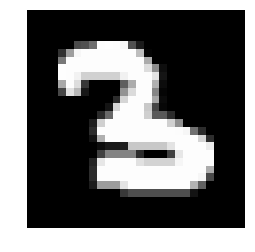

In [4]:
# get random sample index, rerun this cell for different samples
sample_id = np.random.randint(tr_img.shape[0])

print('H & W of the images:', H, ', ', W)
print('# of classes:', C)
print('random example:')
print('image class/label one hot:', tr_lbl[sample_id], ', or non one hot:', np.argmax(tr_lbl[sample_id]))

plt.imshow(tr_img[sample_id], cmap=plt.gray())
plt.axis('off')
plt.show()

In [5]:
# If you want to debug, or just check inside the code, it might we worth it to take a smaller dataset for speed up:
# remember to reload the entire data and make it one-hot again if you want to run on the entire data set
tr_img = tr_img[:1000]
tr_lbl = tr_lbl[:1000]
va_img = va_img[:1000]
va_lbl = va_lbl[:1000]
te_img = te_img[:1000]
te_lbl = te_lbl[:1000]
N_tr, N_va, N_te = 1000, 1000, 1000

# Import the model class:
### This imports a trainable network, please look inside for the API.
### It implements a simple, fully connected net with a flexible amount and size of the hidden layers. Furthermore, it includes dropout and batch normalization

In [10]:
class NeuralNet(object):
    """
    Implements a simple Neural Network not unlike a vanilla net
    The only differences are an implementation of dropout and Batch Normalisation in every forward and backward layer

    arguments:
    input_size       = number of features per sample in the training data
    layer_sizes      = list or numpy array, with each entry i corresponding to the amount of hidden neurons in the ith hidden layer
    output_size      = number of output classes for prediction

    functions:
    forward_pass()
    backward_pass()
    test()
    train()
    """

    def __init__(self, input_size, layer_sizes, output_size):


        # store the __init__ variables for other functions
        self.D        = input_size
        self.lay_size = layer_sizes
        self.C        = output_size

        # create layer variable weights and biases in a dictionary
        self.var = {}
        prev_size = np.hstack((self.D, layer_sizes))                              # temporary lookup array for weight variable sizes

        for i, size in enumerate(layer_sizes):                                    # iterate over each layer

            cur_W             = ('W%d' % (i+1))
            self.var[cur_W]   = np.random.normal(0.0, 0.1, (prev_size[i], size))  # add weight variable
            cur_b             = ('b%d' % (i+1))
            self.var[cur_b]   = np.zeros(size)                                    # add bias variable
            cur_gam           = ('gam%d' % (i+1))
            self.var[cur_gam] = np.zeros(size)                                    # add gamma variable
            cur_bet           = ('bet%d' % (i+1))
            self.var[cur_bet] = np.zeros(size)                                    # add beta variable

        self.var['Wout'] = np.random.normal(0.0, 0.1, (layer_sizes[-1], self.C))  # add output layer weight variable
        self.var['bout'] = np.zeros(self.C)                                       # add output layer bias variable

        # keep track of bn_params
        self.bn_params = []
        self.bn_params = [{'mode': 'train'} for i in range(len(layer_sizes))]

    def forward_pass(self, X, y, drop_prob):
        """
        A single forward pass, affine layers using the sigmoid nonlinearity activation function
        Performs dropout and Batch Normalization after affine and before activation
        Last layer is implements an affine layer plus a softmax
        Also calculates the loss, prediction, and prediction derivative

        arguments:
        X       = numpy matrix, minibatch of N samples, each with self.D features
        y       = numpy matrix, minibatch of one hot encoded labels for same N samples as X

        returns:
        loss    = scalar,       softmax prediction loss for current X and y, does NOT contain regularisation loss
        pred    = numpy array,  predicted class for each of N samples
        acc     = scalar,       percentage of correctly predicted classes for current X and y
        dpred   = numpy_array,  derivative of the prediction, (including backprop through softmax layer), internal use for backprop
        cache   = dictionary,   keeps track of all the cahce necessary for backpropagation later on
        """

        # create cache dictionary to keep around data required for backward pass
        cache = {}

        # hidden layer calculations
        inp = X                                                                    # initialise input for following layer iteration
        for i, size in enumerate(self.lay_size):                                   # iterate over each layer

            cur_W                  = self.var[('W%d' % (i+1))]
            cur_b                  = self.var[('b%d' % (i+1))]
            cur_gam                = self.var[('gam%d' % (i+1))]
            cur_bet                = self.var[('bet%d' % (i+1))]
            h, cur_cache           = BN_Dr_sig_layer_forward(inp, cur_W, cur_b,    # forward layer calculation
                                                             drop_prob,            # dropout parameters
                                                             cur_gam, cur_bet, self.bn_params[i])   # batch normalization parameters
            inp                    = h
            cache[('c%d' % (i+1))] = cur_cache


        # output layer calculation
        pred_sof, cout = softmax_layer_forward(h, self.var['Wout'], self.var['bout']) # final forward layer calculation
        cache['cout']  = cout
        pred           = np.argmax(pred_sof, axis=1)                               # prediction from softmax distribution to specific class
        acc            = np.sum(pred == np.argmax(y, axis=1)) * 1.0 / X.shape[0]   # final forward layer calculation


        # loss & prediction derivative calculation
        loss, dpred                = cross_entropy_loss(pred_sof, y)


        return loss, pred, acc, dpred, cache


    def backward_pass(self, dpred, cache):
        """
        implements backpropagation through all the layers in the network, saves the derivatives (does NOT update variables!)

        arguments:
        dpred   = numpy matrix, contains the derivatives for the output of the final layer
        cache   = dictionary,   forward pass cache necessary for backward pass derivative calculations

        returns:
        none
        """

        # calculate layer weights and bias derivatives in a dictionary
        self.der = {}

        # output layer calculation
        dh, dW, db       = affine_layer_backward(dpred, cache['cout'])             # backpropagate through final layer without softmax
        dout             = dh                                                      # initialise output deriv for following layer iteration
        self.der['Wout'] = dW                                                      # update output layer weight derivatives
        self.der['bout'] = db                                                      # update output layer bias derivatives

        # hidden layer calculations
        for i_unrev, size in enumerate(reversed(self.lay_size)):                   # iterate backwards over each layer

            i                         = len(self.lay_size)-i_unrev                 # create reversed i. +1 not necessary due to len()
            cur_cac                   = cache[('c%d' % (i))]
            dh, dW, db, dgam, dbet    = BN_Dr_sig_layer_backward(dout, cur_cac)    # backpropagate through layer
            dout                      = dh
            self.der[('W%d' % (i))]   = dW                                         # update weight derivatives for layer i
            self.der[('b%d' % (i))]   = db                                         # update bias derivatives layer i
            self.der[('gam%d' % (i))] = dgam                                       # update gamma (BN) derivatives layer i
            self.der[('bet%d' % (i))] = dbet                                       # update beta (BN) derivatives layer i


    def test(self, X, y):
        """
        implements a forward pass and returns the prediction for testing

        arguments:
        X, y    = like in forward_pass()

        returns:
        loss    = like in forward_pass()
        pred    =   ,,
        acc     =   ,,
        """

        loss, pred, acc, _, _ = self.forward_pass(X, y, drop_prob=0.0)

        return loss, pred, acc


    def train(self, X_tr, y_tr, X_va, y_va, number_epochs, batch_size, learning_rate, reg_strength, drop_prob, print_every, verbose):
        """
        this is the core function, it actually trains our model. It keeps track of the best performance on the validation set.
        Final variables are taken from this best performance

        arguments:
        X_tr, X_va = numpy matrix, minibatch of N samples, each with self.D features
        y_tr, y_va =
        number_epochs = int,    total number of epochs for training
        batch_size    = int,    batch size of training samples per forward and backward pass
        learning_rate = scalar, learning rate for stochastic gradient descent
        reg_strength  = scalar, regularization strenght (L2 implemented)
        print_every   = int,    print performance during training every this amount of iterations
        verbose       = bool,   print performance during training yes or no

        returns:
        tr_loss_hist  = list,   containing training set loss history (without regularisation loss!)
        va_loss_hist  = list,   containing validation set loss history (without regularisation loss!)
        tr_acc_hist   = list,   containing training set accuracy history
        va_acc_hist   = list,   containing validation set accuracy history
        """

        # keep the best performing variables around during training:
        best_va_var  = {}
        best_va_acc  = 0

        # initialise lists to keep track of the training history
        tr_acc_hist  = []
        va_acc_hist  = []
        tr_loss_hist = []
        va_loss_hist = []

        # some dependent parameters
        N              = X_tr.shape[0]
        iterations     = N * number_epochs / batch_size
        iter_per_epoch = iterations / number_epochs
        #X_ba, y_ba = get_random_batch(X_tr, y_tr, batch_size) # uncomment this line for the 'overfit hack'
        for e in range(number_epochs):          # iterate over epochs

            for i in range(int(iter_per_epoch)):     # iterate over iterations per epochs

                # get current validation performance
                va_loss, _, va_acc  = self.test(X_va, y_va)

                # forward and backpropagate
                X_ba, y_ba = get_random_batch(X_tr, y_tr, batch_size) # comment this line out for the 'overfit hack'
                tr_loss, pred, tr_acc, dpred, cache = self.forward_pass(X_ba, y_ba, drop_prob)
                self.backward_pass(dpred, cache)

                # update loss histories
                tr_acc_hist.append(tr_acc)
                va_acc_hist.append(va_acc)
                tr_loss_hist.append(tr_loss)
                va_loss_hist.append(va_loss)

                # update the best validation set performing variables
                if va_acc > best_va_acc:
                    best_va_acc = copy.deepcopy(va_acc)
                    best_va_var = copy.deepcopy(self.var)

                # update variables
                for var_key, var  in self.var.items():
                    if 'W' in var_key:                                     # only regularise W matrices, not the bias arrays
                        self.var[var_key] -= reg_strength  * var           # regularisation
                    self.var[var_key] -= learning_rate * self.der[var_key] # derivatives

                # print output during training
                if (e*iter_per_epoch + i) % print_every == 0 and verbose:
                    print('iteration %4d/%4d, training accuracy: %.2f, training loss: %.4f' \
                          % (e*iter_per_epoch + i, iterations, tr_acc, tr_loss))

            # print output during training per epoch
            #if verbose:
            #    print('epoch %2d/%2d, validation accuracy: %.2f'% (e+1, number_epochs, va_acc))

        # append final accuracies to history
        _, _, tr_acc = self.test(X_tr, y_tr)
        _, _, va_acc = self.test(X_va, y_va)
        tr_acc_hist.append(tr_acc)
        va_acc_hist.append(va_acc)

        # final check for the best validation set performing variables
        if va_acc > best_va_acc:
            best_va_acc = copy.deepcopy(va_acc)
            best_va_var = copy.deepcopy(self.var)

        # replace variables with the best performing ones
        self.var = {}
        self.var = best_va_var

        return tr_loss_hist, va_loss_hist, tr_acc_hist, va_acc_hist

# Now for the fun stuff! Let's train out model

In [14]:
# Hyperparameters, you should play around with these!:

layer_sizes = [100, 50, 25]  # size per hidden layer

num_epoch   = 1000            # total number of epochs for training
batch_size  = 4             # batch size of training samples per forward and backward pass
lrn_rate    = 5e-5            # learning rate for stochastic gradient descent
reg_str     = 1e-6            # regularization strenght (L2 implemented)
drop_prob   = 0.5             # the probability with which every neuron is dropped, should be in range [0-1) (NOT 1!)
print_every = 50              # during training, print current performance every this amount of iterations

# a Vanilla net takes a flat feature array as input instead of a 2D image, so change the shape of the images:
tr_img_flat = tr_img.reshape(N_tr, -1)
va_img_flat = va_img.reshape(N_va, -1)
te_img_flat = te_img.reshape(N_te, -1)

# initialise a Vanilla network class, please look in the Models.py file for its API and workings
Net = NeuralNet(input_size       = (H*W),
                layer_sizes      = layer_sizes,
                output_size      = C)
# train
tr_loss_hist, va_loss_hist, tr_acc_hist, va_acc_hist = Net.train(tr_img_flat, tr_lbl, va_img_flat, va_lbl,
                                                                    number_epochs = num_epoch,
                                                                    batch_size    = batch_size,
                                                                    learning_rate = lrn_rate,
                                                                    reg_strength  = reg_str,
                                                                    drop_prob     = drop_prob,
                                                                    print_every   = print_every,
                                                                    verbose       = True)

print('\nfinal training loss: %.4f' % (tr_loss_hist[-1]))
print('final training accuracy: %.2f, best validation accuracy: %.2f' % (tr_acc_hist[-1], np.max(va_acc_hist)))

# test
loss, pred, final_test_accuracy = Net.test(te_img_flat, te_lbl)
print('\nfinal test accuracy: %.2f' % final_test_accuracy)

iteration    0/250000, training accuracy: 0.00, training loss: 2.3357


iteration   50/250000, training accuracy: 0.00, training loss: 2.3151


iteration  100/250000, training accuracy: 0.00, training loss: 2.2948


iteration  150/250000, training accuracy: 0.00, training loss: 2.2748


iteration  200/250000, training accuracy: 0.00, training loss: 2.2552


iteration  250/250000, training accuracy: 0.00, training loss: 2.2358


iteration  300/250000, training accuracy: 0.00, training loss: 2.2167


iteration  350/250000, training accuracy: 0.00, training loss: 2.1979


iteration  400/250000, training accuracy: 0.00, training loss: 2.1794


iteration  450/250000, training accuracy: 0.00, training loss: 2.1612


iteration  500/250000, training accuracy: 0.00, training loss: 2.1433


iteration  550/250000, training accuracy: 0.50, training loss: 2.1257


iteration  600/250000, training accuracy: 0.50, training loss: 2.1085


iteration  650/250000, training accuracy: 0.50, training loss: 2.0915


iteration  700/250000, training accuracy: 0.50, training loss: 2.0748


iteration  750/250000, training accuracy: 0.50, training loss: 2.0583


iteration  800/250000, training accuracy: 0.50, training loss: 2.0422


iteration  850/250000, training accuracy: 0.50, training loss: 2.0264


iteration  900/250000, training accuracy: 0.50, training loss: 2.0108


iteration  950/250000, training accuracy: 0.50, training loss: 1.9956


iteration 1000/250000, training accuracy: 0.50, training loss: 1.9806


iteration 1050/250000, training accuracy: 0.50, training loss: 1.9659


iteration 1100/250000, training accuracy: 0.50, training loss: 1.9515


iteration 1150/250000, training accuracy: 0.50, training loss: 1.9373


iteration 1200/250000, training accuracy: 0.50, training loss: 1.9235


iteration 1250/250000, training accuracy: 0.50, training loss: 1.9099


iteration 1300/250000, training accuracy: 0.50, training loss: 1.8965


iteration 1350/250000, training accuracy: 0.50, training loss: 1.8834


iteration 1400/250000, training accuracy: 0.50, training loss: 1.8706


iteration 1450/250000, training accuracy: 0.50, training loss: 1.8580


iteration 1500/250000, training accuracy: 0.50, training loss: 1.8457


iteration 1550/250000, training accuracy: 0.50, training loss: 1.8337


iteration 1600/250000, training accuracy: 0.50, training loss: 1.8218


iteration 1650/250000, training accuracy: 0.50, training loss: 1.8102


iteration 1700/250000, training accuracy: 0.50, training loss: 1.7989


iteration 1750/250000, training accuracy: 0.50, training loss: 1.7878


iteration 1800/250000, training accuracy: 0.50, training loss: 1.7769


iteration 1850/250000, training accuracy: 0.50, training loss: 1.7663


iteration 1900/250000, training accuracy: 0.50, training loss: 1.7558


iteration 1950/250000, training accuracy: 0.50, training loss: 1.7456


iteration 2000/250000, training accuracy: 0.50, training loss: 1.7356


iteration 2050/250000, training accuracy: 0.50, training loss: 1.7258


iteration 2100/250000, training accuracy: 0.50, training loss: 1.7162


iteration 2150/250000, training accuracy: 0.50, training loss: 1.7068


iteration 2200/250000, training accuracy: 0.50, training loss: 1.6976


iteration 2250/250000, training accuracy: 0.50, training loss: 1.6887


iteration 2300/250000, training accuracy: 0.50, training loss: 1.6798


iteration 2350/250000, training accuracy: 0.50, training loss: 1.6712


iteration 2400/250000, training accuracy: 0.50, training loss: 1.6628


iteration 2450/250000, training accuracy: 0.50, training loss: 1.6545


iteration 2500/250000, training accuracy: 0.50, training loss: 1.6464


iteration 2550/250000, training accuracy: 0.50, training loss: 1.6385


iteration 2600/250000, training accuracy: 0.50, training loss: 1.6308


iteration 2650/250000, training accuracy: 0.50, training loss: 1.6232


iteration 2700/250000, training accuracy: 0.50, training loss: 1.6158


iteration 2750/250000, training accuracy: 0.50, training loss: 1.6085


iteration 2800/250000, training accuracy: 0.50, training loss: 1.6014


iteration 2850/250000, training accuracy: 0.50, training loss: 1.5944


iteration 2900/250000, training accuracy: 0.50, training loss: 1.5876


iteration 2950/250000, training accuracy: 0.50, training loss: 1.5809


iteration 3000/250000, training accuracy: 0.50, training loss: 1.5743


iteration 3050/250000, training accuracy: 0.50, training loss: 1.5679


iteration 3100/250000, training accuracy: 0.50, training loss: 1.5617


iteration 3150/250000, training accuracy: 0.50, training loss: 1.5555


iteration 3200/250000, training accuracy: 0.50, training loss: 1.5495


iteration 3250/250000, training accuracy: 0.50, training loss: 1.5436


iteration 3300/250000, training accuracy: 0.50, training loss: 1.5378


iteration 3350/250000, training accuracy: 0.50, training loss: 1.5321


iteration 3400/250000, training accuracy: 0.50, training loss: 1.5265


iteration 3450/250000, training accuracy: 0.50, training loss: 1.5211


iteration 3500/250000, training accuracy: 0.50, training loss: 1.5157


iteration 3550/250000, training accuracy: 0.50, training loss: 1.5105


iteration 3600/250000, training accuracy: 0.50, training loss: 1.5053


iteration 3650/250000, training accuracy: 0.50, training loss: 1.5003


iteration 3700/250000, training accuracy: 0.50, training loss: 1.4953


iteration 3750/250000, training accuracy: 0.50, training loss: 1.4905


iteration 3800/250000, training accuracy: 0.50, training loss: 1.4857


KeyboardInterrupt: 

# Visualise the training of your last trained model

In [28]:
# create the plot inside the ipython notebook
%matplotlib inline
fig = plt.figure()

# plot training set and validation set loss histories
plt.subplot(2, 1, 1)
ep_axis = np.arange(len(tr_loss_hist)) * 1.0 / len(tr_loss_hist) * num_epoch
plt.title('Training loss (softmax loss without regularisatioin loss)[-]')
plt.xlabel('Epoch')
plt.plot(ep_axis, tr_loss_hist, label='training set')
plt.plot(ep_axis, va_loss_hist, label='validation set')
plt.legend(loc='lower left')

# plot training set and validation set accuracies
plt.subplot(2, 1, 2)
ep_axis = np.arange(len(tr_acc_hist)) * 1.0 / len(tr_acc_hist) * num_epoch
plt.title('Training & Validation accuracy (%)')
plt.xlabel('Epoch')
plt.plot(ep_axis, tr_acc_hist, label='train')
plt.plot(ep_axis, va_acc_hist, label='validation')
plt.legend(loc='upper left')


plt.gcf().set_size_inches(15, 12)
plt.show()

# Discussion
After playing around with the model a bit, a few key characteristics are interesting to notice:

#### robustness and convergence
The model is quite robust, but also trains extremely slow, somtimes even plateauing the accuracy and loss in the beginning.
A quick hack to check the validity of the model, is to limit the batches the batch size, and feed the network the same batch every iteration: i.e. overfitting the model. (some comment talk about this and call it the 'overfit hack')


Once we do this, it is possible to learn to a 100%, meaning the model is indeed valid.

The problems for convergence are therefore likely along the line of:
1. The model is not powerfull enough to fit the MNIST data set (likely since we are not even using the convolutional nets)
2. The implementation is not efficient and robust enough

#### regularisation
Dropout and batch normalisation act as regularizers, reducing the need for the L2 regularization. BN alone however is not enough, because when both dropout and L2 strenght are put to 0, the validation accuracy lacks compared to training accuracy. It seems none of the three is able to perform enough regularization on its own.

